In [ ]:
from IPython.display import clear_output
from google.colab import files
files.upload()
from google.colab import drive
drive.mount('/content/drive')
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d atulanandjha/lfwpeople
!unzip lfwpeople.zip
!tar -xvzf lfw-funneled.tgz
!rm lfw-funneled.tgz lfwpeople.zip
clear_output()

Additional options:
* add Gaussian noise in discriminator step
* add one-sided label smoothing
* add spectral norm to discriminator (CNN and opt. to Linears)
* get more images
* train for more epochs


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import torch
import torchvision
import torch.nn as nn
from torchvision import transforms as T

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from glob import glob
from tqdm.notebook import trange, tqdm

torch.autograd.set_detect_anomaly(True)

In [ ]:
img_dir = glob('lfw_funneled/'+'/*/*')
img_dir = [str(x) for x in img_dir]

df = pd.DataFrame(img_dir, columns=['Image_dir'])
df['Name'] = df['Image_dir'].str.split('/', expand=True).loc[:, [1,]]

bush_data = df[df.Name == 'George_W_Bush']
powel_data = df[df.Name == 'Colin_Powell']

In [ ]:
torch.random.manual_seed(123)
torch.cuda.manual_seed(123)

IMAGE_SIZE = 128
BATCH_SIZE = 16
epochs = 200
PATH = r'/content/drive/My Drive/data/swap_gan_model_vgg.pth' # drop '_vgg' to presaved efficient_b0 (70 epochs)
weights_path = r'/content/drive/My Drive/data/vgg_face_dag.pth'
PATH_SCALED = r'/content/drive/My Drive/data/swap_gan_model_vgg_scaled.pth'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
from numpy.ma.core import multiply
from torchvision.transforms.transforms import Lambda
train_transforms = T.Compose([
                              T.ToPILImage(),
                              T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                              T.RandomHorizontalFlip(p=0.5),
                              T.RandomRotation(degrees=(-10, 10)),
                              T.ToTensor(),
                              # for transfer learning
                              #T.Normalize(mean=[0.485, 0.456, 0.406], 
                              #            std=[0.229, 0.224, 0.225])
])
# for pretrained vgg_face discriminator
disc_transforms = T.Compose([
                             T.ToPILImage(),
                             T.Resize((224, 224)),
                             T.ToTensor(),
                             T.Lambda(lambda t: t*255),
                             T.Normalize(mean=(129.186279296875, 104.76238250732422, 93.59396362304688),
                                         std=(1, 1, 1))
])

In [ ]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def crop_face(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 5)
    if len(faces) > 0:
        for x, y, w, h in faces:
            image2 = image[y: y+h, x: x+w, :]
        image2 = cv2.resize(image2, (IMAGE_SIZE, IMAGE_SIZE))
        return image2, 1
    return image, 0

In [ ]:
# get cropped faces
bush_images, powel_images = [], []
for dataset in [bush_data, powel_data]:
    name = dataset.iloc[0,1]
    for path in dataset['Image_dir'].values:
        img = cv2.imread(path)
        img, is_detected = crop_face(img)
        if is_detected:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            if name == 'George_W_Bush':
                bush_images.append(img)
            else:
                powel_images.append(img)
        else:
            continue
bush_images = np.array(bush_images)
powel_images = np.array(powel_images)

In [ ]:
class SwapDataset(torch.utils.data.Dataset):
    def __init__(self, dataA, dataB):
        self.dataA = np.concatenate([face[None] for face in dataA])/255.
        self.dataB = np.concatenate([face[None] for face in dataB])/255.

    def __len__(self):
        return min(len(self.dataA), len(self.dataB))

    def __getitem__(self, ix):
        imgA, imgB = self.dataA[ix], self.dataB[ix]
        return imgA, imgB

    def collate_fn(self, batch):
        imgsA, imgsB = list(zip(*batch))
        imgsA, imgsB = [torch.Tensor(i).permute(0,3,1,2).to(device) for i in [imgsA, imgsB]]
        return imgsA, imgsB

In [ ]:
dataset = SwapDataset(bush_images, powel_images)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=dataset.collate_fn)

In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class Reshape(nn.Module):
    def __init__(self, shape=(256, 5, 5)):
        super().__init__()
        self.shape = shape
        
    def forward(self, input):
        return input.view(-1, *self.shape)

class SwapNet(nn.Module):
    def __init__(self, ngpu=1, features=1024):
        super(SwapNet, self).__init__()
        self.ngpu = ngpu
        self.encoder = nn.Sequential(
                                    nn.Conv2d(3, 512, 3, stride=3, padding=1),
                                    nn.LeakyReLU(0.1, True),
                                    nn.MaxPool2d(2, stride=2),  
                                    nn.Conv2d(512, 256, 3, stride=2, padding=1), 
                                    nn.LeakyReLU(0.1,True),
                                    nn.MaxPool2d(2, stride=1),
                                    nn.Conv2d(256, 128, 3, stride=2, padding=1), 
                                    nn.LeakyReLU(0.1,True),
                                    nn.Flatten(),
                                    nn.Tanh(),            
                                    nn.Linear(3200, 2048),
                                    nn.Sigmoid()
                                    )
        
        self.mean = nn.Linear(2048, features)
        self.std = nn.Linear(2048, features)

        self.decoder_A = nn.Sequential(
                                       nn.Linear(features, 3200),
                                       nn.Tanh(),
                                       Reshape(shape=(128, 5, 5)),            
                                       nn.ConvTranspose2d(128, 256, kernel_size=4, stride=3, padding=0), #16x16 
                                       nn.LeakyReLU(0.1, False),
                                       nn.ConvTranspose2d(256, 512, kernel_size=4, stride=2, padding=1), #32x32 
                                       nn.LeakyReLU(0.1, False),
                                       nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1), #64x64 
                                       nn.LeakyReLU(0.1, False),
                                       nn.ConvTranspose2d(512, 3, kernel_size=4, stride=2, padding=1),
                                       nn.Sigmoid(),
                                       )
        self.decoder_B = nn.Sequential(
                                       nn.Linear(features, 3200),
                                       nn.Tanh(),
                                       Reshape(shape=(128, 5, 5)),            
                                       nn.ConvTranspose2d(128, 256, kernel_size=4, stride=3, padding=0), #16x16 
                                       nn.LeakyReLU(0.1, False),
                                       nn.ConvTranspose2d(256, 512, kernel_size=4, stride=2, padding=1), #32x32 
                                       nn.LeakyReLU(0.1, False),
                                       nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1), #64x64 
                                       nn.LeakyReLU(0.1, False),
                                       nn.ConvTranspose2d(512, 3, kernel_size=4, stride=2, padding=1),
                                       nn.Sigmoid(),
                                       )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        sample = mu + (eps * std) 
        return sample

    def forward(self, x, select='A'):
        x = self.encoder(x)
  
        mu, logvar = self.mean(x), self.std(x)
        z = self.reparameterize(mu, logvar)

        if select == 'A':
            y = self.decoder_A(z)
        else:
            y = self.decoder_B(z)
        
        return y, mu, logvar

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu=1):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        
        self.discriminator = nn.Sequential(
                                           nn.Conv2d(3, 256, kernel_size=3, stride=2),
                                           nn.ReLU(True),
                                           nn.Conv2d(256, 128, kernel_size=3, stride=2),
                                           nn.ReLU(True),    
                                           nn.Conv2d(128, 64, 3, stride=2),
                                           nn.ReLU(True),   
                                           nn.Conv2d(64, 32, 3, stride=2),
                                           nn.ReLU(True),   
                                           nn.Flatten(),
                                           nn.Linear(1568, 512),
                                           nn.ReLU(True),     
                                           nn.Linear(512, 128),
                                           nn.LeakyReLU(0.1, True), 
                                           nn.Dropout(0.5), ##
                                           nn.Linear(128, 1),
                                           nn.Sigmoid(),  # comment if BCE with logits
                                           ) 
    def forward(self, x):
        return self.discriminator(x)

In [ ]:
def load_model(path, device=device):
    if device == 'cuda':
        checkpoint = torch.load(path)
    else:
        checkpoint = torch.load(path, map_location=torch.device('cpu'))
    epoch = checkpoint['epoch']
    model = checkpoint['model']
    D_A = checkpoint['D_A']
    D_B = checkpoint['D_B']
    optimizerA = checkpoint['optimizerA']
    optimizerB = checkpoint['optimizerB']
    optimizerD_A = checkpoint['optimizerD_A']
    optimizerD_B = checkpoint['optimizerD_B']
    return model, D_A, D_B, optimizerA, optimizerB, optimizerD_A, optimizerD_B, epoch

In [ ]:
class Vgg_face_dag(nn.Module):

    def __init__(self):
        super(Vgg_face_dag, self).__init__()
        self.meta = {'mean': [129.186279296875, 104.76238250732422, 93.59396362304688],
                     'std': [1, 1, 1],
                     'imageSize': [224, 224, 3]}
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_3 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_3 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.fc6 = nn.Linear(in_features=25088, out_features=4096, bias=True)
        self.relu6 = nn.ReLU(inplace=True)
        self.dropout6 = nn.Dropout(p=0.5)
        self.fc7 = nn.Linear(in_features=4096, out_features=4096, bias=True)
        self.relu7 = nn.ReLU(inplace=True)
        self.dropout7 = nn.Dropout(p=0.5)
        self.fc8 = nn.Linear(in_features=4096, out_features=2622, bias=True)

    def forward(self, x0):
        x1 = self.conv1_1(x0)
        x2 = self.relu1_1(x1)
        x3 = self.conv1_2(x2)
        x4 = self.relu1_2(x3)
        x5 = self.pool1(x4)
        x6 = self.conv2_1(x5)
        x7 = self.relu2_1(x6)
        x8 = self.conv2_2(x7)
        x9 = self.relu2_2(x8)
        x10 = self.pool2(x9)
        x11 = self.conv3_1(x10)
        x12 = self.relu3_1(x11)
        x13 = self.conv3_2(x12)
        x14 = self.relu3_2(x13)
        x15 = self.conv3_3(x14)
        x16 = self.relu3_3(x15)
        x17 = self.pool3(x16)
        x18 = self.conv4_1(x17)
        x19 = self.relu4_1(x18)
        x20 = self.conv4_2(x19)
        x21 = self.relu4_2(x20)
        x22 = self.conv4_3(x21)
        x23 = self.relu4_3(x22)
        x24 = self.pool4(x23)
        x25 = self.conv5_1(x24)
        x26 = self.relu5_1(x25)
        x27 = self.conv5_2(x26)
        x28 = self.relu5_2(x27)
        x29 = self.conv5_3(x28)
        x30 = self.relu5_3(x29)
        x31_preflatten = self.pool5(x30)
        x31 = x31_preflatten.view(x31_preflatten.size(0), -1)
        x32 = self.fc6(x31)
        x33 = self.relu6(x32)
        x34 = self.dropout6(x33)
        x35 = self.fc7(x34)
        x36 = self.relu7(x35)
        x37 = self.dropout7(x36)
        x38 = self.fc8(x37)
        return x38

def vgg_face_dag(weights_path=None, **kwargs):
    model = Vgg_face_dag()
    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)
    return model

def get_model_pretrained():
    model = vgg_face_dag(weights_path=weights_path)

    for param in model.parameters():
        param.requires_grad = False

    return model

In [ ]:
class DiscriminatorP(nn.Module):
    def __init__(self):
        super(DiscriminatorP, self).__init__()
        self.face_model = get_model_pretrained()
        self.fc = nn.Sequential(
            nn.Linear(2622, 1300),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1300, 650),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(650, 325),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(325, 150),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(150, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        input = input.detach()
        input = torch.cat([disc_transforms(t.squeeze())[None].to(device) for t in input])
        output = self.face_model(input)
        output = self.fc(output)        
        return output

In [ ]:
# to init weights with normal distribution
def weights_init(obj):
    classname = obj.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(obj.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(obj.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(obj.bias.data, 0.0)

In [ ]:
def switch_params(model, on=True):
    for param in model.parameters():
        param.requires_grad = on

def get_pretrained_discriminator():
    model = torchvision.models.efficientnet_b0(pretrained=True, progress=False)
    switch_params(model, False)
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(2,2))
    model.classifier = nn.Sequential(
                                     nn.Linear(5120, 3200),
                                     nn.ReLU(True), 
                                     nn.Dropout(0.5),
                                     nn.Linear(3200, 1024),
                                     nn.ReLU(True),
                                     nn.Dropout(0.5),
                                     nn.Linear(1024, 512),
                                     nn.ReLU(True),
                                     nn.Dropout(0.5),    
                                     nn.Linear(512, 128),
                                     nn.LeakyReLU(0.1, True), 
                                     nn.Dropout(0.5), ##
                                     nn.Linear(128, 1),
                                     nn.Sigmoid(),
    )
    return model  

In [ ]:
model = SwapNet().to(device).apply(weights_init)
#D_A = Discriminator().to(device).apply(weights_init)
#D_B = Discriminator().to(device).apply(weights_init)

# pretrained efficient_b0 discriminator may learn too fast and make generator loss increase significantly
#D_A = get_pretrained_discriminator().to(device)
#D_B = get_pretrained_discriminator().to(device)

# vgg_face discriminator
D_A = DiscriminatorP().to(device)
D_B = DiscriminatorP().to(device)

In [ ]:
from torchsummary import summary

summary(model, (3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 512, 43, 43]          14,336
         LeakyReLU-2          [-1, 512, 43, 43]               0
         MaxPool2d-3          [-1, 512, 21, 21]               0
            Conv2d-4          [-1, 256, 11, 11]       1,179,904
         LeakyReLU-5          [-1, 256, 11, 11]               0
         MaxPool2d-6          [-1, 256, 10, 10]               0
            Conv2d-7            [-1, 128, 5, 5]         295,040
         LeakyReLU-8            [-1, 128, 5, 5]               0
           Flatten-9                 [-1, 3200]               0
             Tanh-10                 [-1, 3200]               0
           Linear-11                 [-1, 2048]       6,555,648
          Sigmoid-12                 [-1, 2048]               0
           Linear-13                 [-1, 1024]       2,098,176
           Linear-14                 [-

In [ ]:
summary(D_A, (3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
input_size = 3*128*128
class KLDLoss(nn.Module):
    def forward(self, mu, logvar):
        kld = -0.5 * torch.sum(1 + logvar - torch.pow(mu, 2) - torch.exp(logvar))
        return kld

# another approach for kld loss
class KLDLossScaled(nn.Module):
    def forward(self, mean, logvar):
        latent_kl = -0.5 * (1 + logvar - mean.pow(2) - logvar.exp()).mean(dim=0)
        total_kl = latent_kl.sum()
        return total_kl    

reconstruction_loss = torch.nn.functional.binary_cross_entropy
kld_loss = KLDLoss()
kld_loss_scaled = KLDLossScaled()
criterion = lambda y, x, mu, logvar: reconstruction_loss(y, x, reduction='sum') + kld_loss_scaled(mu, logvar) # / (input_size * BATCH_SIZE)

optimizerA = torch.optim.Adam(
    [{'params': model.encoder.parameters()}, {'params': model.std.parameters()}, {'params': model.mean.parameters()}, {'params': model.decoder_A.parameters()}], 
    lr=5e-5,betas=(0.5, 0.999), weight_decay=5e-6,
) 
optimizerB = torch.optim.Adam(
    [{'params': model.encoder.parameters()}, {'params': model.std.parameters()}, {'params': model.mean.parameters()}, {'params': model.decoder_B.parameters()}], 
    lr=5e-5, betas=(0.5, 0.999), weight_decay=5e-6,
)

criterion_D = nn.BCELoss() #BCEWithLogitsLoss()

optimizerD_A = torch.optim.SGD(D_A.parameters(), lr=5e-3, weight_decay=5e-6) # init=5e-2, lr=5e-5
optimizerD_B = torch.optim.SGD(D_B.parameters(), lr=5e-3, weight_decay=5e-6)

In [ ]:
def train_discriminator(D, criterion, optimizer, real, fake):
    optimizer.zero_grad()

    with torch.set_grad_enabled(True):
        pred_real = D(real)
        pred_fake = D(fake.detach())  # .detach(): https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
        
        loss_real = criterion(pred_real, torch.ones(real.size(0), 1).to(device))  # torch.full_like(real, 0.9)
        loss_fake = criterion(pred_fake, torch.zeros(fake.size(0), 1).to(device))
        # loss_real.backward() & loss_fake.backward() -> step

        loss = loss_real + loss_fake
        loss.backward(retain_graph=True)

        optimizer.step()

    return loss.item()

# original paper
def train_generator(D, criterion_G, criterion_D, optimizer, x, fake, mu, logvar):
    optimizer.zero_grad()
    
    with torch.set_grad_enabled(True):
        prediction = D(fake.detach())  # .detach(): https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
        #before = list(D.parameters())[0].clone()

        target = torch.ones(x.size(0), 1).to(device)
        d_loss = criterion_D(prediction, target)
        d_loss.backward(retain_graph=True)
        d_loss = d_loss.item()

        if criterion_G is not None:   
            g_loss = criterion_G(fake, x, mu, logvar)  # ERROR here: as in original we call model in train mode twice before first backward
            grads = torch.ones_like(g_loss)            # only recalculate fake, mu, logvar after model update (optA) and pass here with optB
            g_loss.backward(grads, retain_graph=True)
            d_loss += g_loss.mean().item()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 10.0)
        optimizer.step()
    #after = list(D.parameters())[0].clone()
    #print(torch.equal(before.data, after.data))  # checking if weights are updating

    return d_loss

In [ ]:
model, D_A, D_B, optimizerA, optimizerB, optimizerD_A, optimizerD_B, _ = load_model(PATH_SCALED)

In [ ]:
# to use mu_B, logvar_B before opt.step use torch.no_grad() for A and B, then set tensor.requires_grad_(True)
# before train_generator. But this generates only noise...
model.train()
D_A.train()
D_B.train()

loss_hist = {'D': list(), 'G': list()}

for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')

    g_loss = 0
    d_loss = 0

    for i, batch in enumerate(tqdm(dataloader, leave=False), 1):
        x_A, x_B = batch

        fake_A, mu_A, logvar_A = model(x_A)
        with torch.no_grad():
            fake_B, mu_B, logvar_B = model(x_B, select='B')

        d_loss += train_discriminator(D_A, criterion_D, optimizerD_A, x_A, fake_A)
        d_loss += train_discriminator(D_B, criterion_D, optimizerD_B, x_B, fake_B)
        
        g_loss += train_generator(D_A, criterion, criterion_D, optimizerA, x_A, fake_A, mu_A, logvar_A)
        fake_B, mu_B, logvar_B = model(x_B, select='B')
        g_loss += train_generator(D_B, criterion, criterion_D, optimizerB, x_B, fake_B, mu_B, logvar_B)

        fake_A2, mu_A2, logvar_A2 = model(x_A, select='B')

        g_loss += train_generator(D_B, None, criterion_D, optimizerB, x_A, fake_A2, mu_A2, logvar_A2)
        fake_B2, mu_B2, logvar_B2 = model(x_B, select='A')
        g_loss += train_generator(D_A, None, criterion_D, optimizerA, x_B, fake_B2, mu_B2, logvar_B2)

    d_loss /= i*2
    g_loss /= i*4

    loss_hist['D'].append(d_loss)
    loss_hist['G'].append(g_loss)

    print(f'Epoch g_loss: {g_loss:.4f}, d_loss: {d_loss:.4f}')
    print(50*'-')
    if (epoch + 1) % 10 == 0:
        checkpoint = { 
                          'epoch': None,
                          'model': model,
                          'D_A': D_A,
                          'D_B': D_B,
                          'optimizerA': optimizerA,
                          'optimizerB': optimizerB,
                          'optimizerD_A': optimizerD_A,
                          'optimizerD_B': optimizerD_B,
                          }
        torch.save(checkpoint, PATH_SCALED) # PATH_SCALED if scaled KLD loss

Epoch 1/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 263154.6952, d_loss: 1.3932
--------------------------------------------------
Epoch 2/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 257691.1416, d_loss: 1.3913
--------------------------------------------------
Epoch 3/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 254444.9354, d_loss: 1.3897
--------------------------------------------------
Epoch 4/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 253723.7888, d_loss: 1.3881
--------------------------------------------------
Epoch 5/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 249866.3525, d_loss: 1.3872
--------------------------------------------------
Epoch 6/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 247051.9788, d_loss: 1.3870
--------------------------------------------------
Epoch 7/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 245735.6791, d_loss: 1.3858
--------------------------------------------------
Epoch 8/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 244647.2584, d_loss: 1.3845
--------------------------------------------------
Epoch 9/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 243982.4847, d_loss: 1.3828
--------------------------------------------------
Epoch 10/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 243568.1790, d_loss: 1.3803
--------------------------------------------------
Epoch 11/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 243280.1033, d_loss: 1.3799
--------------------------------------------------
Epoch 12/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 242924.1756, d_loss: 1.3775
--------------------------------------------------
Epoch 13/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 242877.7059, d_loss: 1.3755
--------------------------------------------------
Epoch 14/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 242363.7262, d_loss: 1.3733
--------------------------------------------------
Epoch 15/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 241830.6535, d_loss: 1.3714
--------------------------------------------------
Epoch 16/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 241575.4553, d_loss: 1.3688
--------------------------------------------------
Epoch 17/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 241321.4858, d_loss: 1.3640
--------------------------------------------------
Epoch 18/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 241097.4777, d_loss: 1.3612
--------------------------------------------------
Epoch 19/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 240859.5633, d_loss: 1.3567
--------------------------------------------------
Epoch 20/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 240679.9779, d_loss: 1.3526
--------------------------------------------------
Epoch 21/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 240467.8941, d_loss: 1.3451
--------------------------------------------------
Epoch 22/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 240310.1541, d_loss: 1.3380
--------------------------------------------------
Epoch 23/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 240130.2596, d_loss: 1.3250
--------------------------------------------------
Epoch 24/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 240078.9242, d_loss: 1.3161
--------------------------------------------------
Epoch 25/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 239833.5177, d_loss: 1.2959
--------------------------------------------------
Epoch 26/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 239738.9171, d_loss: 1.2652
--------------------------------------------------
Epoch 27/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 239617.2963, d_loss: 1.2397
--------------------------------------------------
Epoch 28/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 239473.1091, d_loss: 1.1823
--------------------------------------------------
Epoch 29/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 239549.6707, d_loss: 1.1316
--------------------------------------------------
Epoch 30/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 239326.1489, d_loss: 1.0616
--------------------------------------------------
Epoch 31/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 239177.4351, d_loss: 1.0215
--------------------------------------------------
Epoch 32/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 239081.7098, d_loss: 0.9583
--------------------------------------------------
Epoch 33/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 239135.3520, d_loss: 0.9068
--------------------------------------------------
Epoch 34/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 238888.8645, d_loss: 0.8518
--------------------------------------------------
Epoch 35/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 238726.2575, d_loss: 0.7818
--------------------------------------------------
Epoch 36/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 238718.3004, d_loss: 0.6912
--------------------------------------------------
Epoch 37/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 238580.6528, d_loss: 0.5753
--------------------------------------------------
Epoch 38/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 238509.7438, d_loss: 0.4617
--------------------------------------------------
Epoch 39/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 238493.7581, d_loss: 0.3601
--------------------------------------------------
Epoch 40/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 238387.9330, d_loss: 0.2868
--------------------------------------------------
Epoch 41/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 238263.5191, d_loss: 0.2215
--------------------------------------------------
Epoch 42/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 238223.5286, d_loss: 0.1950
--------------------------------------------------
Epoch 43/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 238140.4428, d_loss: 0.1722
--------------------------------------------------
Epoch 44/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 238107.7358, d_loss: 0.1558
--------------------------------------------------
Epoch 45/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 238010.0170, d_loss: 0.1433
--------------------------------------------------
Epoch 46/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 237906.2069, d_loss: 0.1364
--------------------------------------------------
Epoch 47/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 237860.9903, d_loss: 0.1282
--------------------------------------------------
Epoch 48/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 237816.3675, d_loss: 0.1104
--------------------------------------------------
Epoch 49/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 237782.9342, d_loss: 0.1054
--------------------------------------------------
Epoch 50/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 237619.3681, d_loss: 0.1084
--------------------------------------------------
Epoch 51/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 237514.9491, d_loss: 0.1127
--------------------------------------------------
Epoch 52/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 237536.9804, d_loss: 0.1000
--------------------------------------------------
Epoch 53/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 237452.6463, d_loss: 0.0914
--------------------------------------------------
Epoch 54/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 237348.5830, d_loss: 0.1051
--------------------------------------------------
Epoch 55/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 237310.5823, d_loss: 0.0883
--------------------------------------------------
Epoch 56/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 237341.3408, d_loss: 0.0824
--------------------------------------------------
Epoch 57/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 237144.4276, d_loss: 0.0901
--------------------------------------------------
Epoch 58/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 237044.1354, d_loss: 0.0951
--------------------------------------------------
Epoch 59/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 237014.2457, d_loss: 0.0901
--------------------------------------------------
Epoch 60/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 236946.1577, d_loss: 0.0769
--------------------------------------------------
Epoch 61/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 236886.1584, d_loss: 0.0857
--------------------------------------------------
Epoch 62/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 236926.2608, d_loss: 0.0689
--------------------------------------------------
Epoch 63/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 236734.7161, d_loss: 0.0676
--------------------------------------------------
Epoch 64/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 236639.6591, d_loss: 0.0671
--------------------------------------------------
Epoch 65/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 236580.6966, d_loss: 0.0648
--------------------------------------------------
Epoch 66/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 236505.3915, d_loss: 0.0679
--------------------------------------------------
Epoch 67/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 236479.7958, d_loss: 0.0521
--------------------------------------------------
Epoch 68/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 236420.6892, d_loss: 0.0620
--------------------------------------------------
Epoch 69/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 236449.7501, d_loss: 0.0611
--------------------------------------------------
Epoch 70/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 236275.1861, d_loss: 0.0590
--------------------------------------------------
Epoch 71/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 236213.0661, d_loss: 0.0519
--------------------------------------------------
Epoch 72/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 236145.1785, d_loss: 0.0546
--------------------------------------------------
Epoch 73/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 236050.2018, d_loss: 0.0643
--------------------------------------------------
Epoch 74/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 236032.9151, d_loss: 0.0784
--------------------------------------------------
Epoch 75/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 236002.7617, d_loss: 0.0526
--------------------------------------------------
Epoch 76/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 235871.3904, d_loss: 0.0578
--------------------------------------------------
Epoch 77/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 235761.4659, d_loss: 0.0491
--------------------------------------------------
Epoch 78/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 235793.3674, d_loss: 0.0746
--------------------------------------------------
Epoch 79/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 235676.8052, d_loss: 0.0542
--------------------------------------------------
Epoch 80/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 235626.5161, d_loss: 0.0411
--------------------------------------------------
Epoch 81/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 235496.6597, d_loss: 0.0467
--------------------------------------------------
Epoch 82/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 235514.4876, d_loss: 0.0480
--------------------------------------------------
Epoch 83/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 235415.6031, d_loss: 0.0475
--------------------------------------------------
Epoch 84/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 235453.8431, d_loss: 0.0382
--------------------------------------------------
Epoch 85/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 235405.6043, d_loss: 0.0376
--------------------------------------------------
Epoch 86/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 235257.5547, d_loss: 0.0611
--------------------------------------------------
Epoch 87/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 235126.0257, d_loss: 0.0417
--------------------------------------------------
Epoch 88/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 235093.1538, d_loss: 0.0645
--------------------------------------------------
Epoch 89/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 235083.8487, d_loss: 0.0457
--------------------------------------------------
Epoch 90/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 234988.4670, d_loss: 0.0500
--------------------------------------------------
Epoch 91/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 234872.2461, d_loss: 0.0527
--------------------------------------------------
Epoch 92/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 234808.6776, d_loss: 0.0529
--------------------------------------------------
Epoch 93/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 234722.8477, d_loss: 0.0417
--------------------------------------------------
Epoch 94/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 234730.2104, d_loss: 0.0432
--------------------------------------------------
Epoch 95/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 234623.6756, d_loss: 0.0551
--------------------------------------------------
Epoch 96/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 234560.7143, d_loss: 0.0385
--------------------------------------------------
Epoch 97/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 234524.0432, d_loss: 0.0331
--------------------------------------------------
Epoch 98/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 234486.5967, d_loss: 0.0499
--------------------------------------------------
Epoch 99/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 234410.4690, d_loss: 0.0303
--------------------------------------------------
Epoch 100/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 234357.5704, d_loss: 0.0568
--------------------------------------------------
Epoch 101/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 234342.5460, d_loss: 0.0359
--------------------------------------------------
Epoch 102/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 234208.9426, d_loss: 0.0306
--------------------------------------------------
Epoch 103/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 234182.6267, d_loss: 0.0503
--------------------------------------------------
Epoch 104/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 234128.2895, d_loss: 0.0453
--------------------------------------------------
Epoch 105/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 234081.6934, d_loss: 0.0321
--------------------------------------------------
Epoch 106/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 234011.7119, d_loss: 0.0603
--------------------------------------------------
Epoch 107/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 234018.1640, d_loss: 0.0338
--------------------------------------------------
Epoch 108/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 233863.4726, d_loss: 0.0226
--------------------------------------------------
Epoch 109/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 233878.6040, d_loss: 0.0294
--------------------------------------------------
Epoch 110/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 233774.3096, d_loss: 0.0757
--------------------------------------------------
Epoch 111/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 233704.6600, d_loss: 0.0455
--------------------------------------------------
Epoch 112/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 233613.0145, d_loss: 0.0560
--------------------------------------------------
Epoch 113/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 233613.5521, d_loss: 0.0945
--------------------------------------------------
Epoch 114/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 233595.6874, d_loss: 0.0563
--------------------------------------------------
Epoch 115/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 233521.7766, d_loss: 0.0649
--------------------------------------------------
Epoch 116/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 233466.5300, d_loss: 0.0341
--------------------------------------------------
Epoch 117/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 233397.8903, d_loss: 0.0307
--------------------------------------------------
Epoch 118/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 233348.8966, d_loss: 0.0305
--------------------------------------------------
Epoch 119/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 233340.0638, d_loss: 0.0470
--------------------------------------------------
Epoch 120/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 233246.0620, d_loss: 0.0872
--------------------------------------------------
Epoch 121/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 233206.6550, d_loss: 0.0459
--------------------------------------------------
Epoch 122/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 233271.7185, d_loss: 0.0775
--------------------------------------------------
Epoch 123/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 233122.8836, d_loss: 0.0663
--------------------------------------------------
Epoch 124/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 233088.8229, d_loss: 0.0373
--------------------------------------------------
Epoch 125/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 233063.1153, d_loss: 0.0451
--------------------------------------------------
Epoch 126/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 232943.5365, d_loss: 0.0266
--------------------------------------------------
Epoch 127/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 232978.8850, d_loss: 0.0632
--------------------------------------------------
Epoch 128/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 232851.2544, d_loss: 0.0617
--------------------------------------------------
Epoch 129/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 232780.7469, d_loss: 0.0813
--------------------------------------------------
Epoch 130/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 232776.1601, d_loss: 0.0559
--------------------------------------------------
Epoch 131/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 232727.7240, d_loss: 0.0422
--------------------------------------------------
Epoch 132/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 232659.7160, d_loss: 0.0541
--------------------------------------------------
Epoch 133/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 232595.5011, d_loss: 0.0572
--------------------------------------------------
Epoch 134/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 232550.0535, d_loss: 0.0411
--------------------------------------------------
Epoch 135/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 232718.6295, d_loss: 0.0894
--------------------------------------------------
Epoch 136/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 232546.9304, d_loss: 0.1323
--------------------------------------------------
Epoch 137/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 232496.4312, d_loss: 0.0609
--------------------------------------------------
Epoch 138/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 232391.2984, d_loss: 0.0612
--------------------------------------------------
Epoch 139/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 232337.1633, d_loss: 0.0432
--------------------------------------------------
Epoch 140/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 232322.5882, d_loss: 0.0775
--------------------------------------------------
Epoch 141/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 232287.0133, d_loss: 0.0751
--------------------------------------------------
Epoch 142/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 232251.9295, d_loss: 0.0205
--------------------------------------------------
Epoch 143/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 232285.5310, d_loss: 0.0412
--------------------------------------------------
Epoch 144/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 232163.6930, d_loss: 0.0870
--------------------------------------------------
Epoch 145/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 232121.2333, d_loss: 0.0525
--------------------------------------------------
Epoch 146/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 232123.7081, d_loss: 0.0601
--------------------------------------------------
Epoch 147/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 232051.3274, d_loss: 0.0673
--------------------------------------------------
Epoch 148/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 232041.0454, d_loss: 0.0675
--------------------------------------------------
Epoch 149/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 232006.1665, d_loss: 0.0643
--------------------------------------------------
Epoch 150/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 231947.2988, d_loss: 0.1100
--------------------------------------------------
Epoch 151/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 231892.4313, d_loss: 0.0330
--------------------------------------------------
Epoch 152/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 231853.2659, d_loss: 0.0388
--------------------------------------------------
Epoch 153/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 231856.2842, d_loss: 0.0709
--------------------------------------------------
Epoch 154/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 231827.5816, d_loss: 0.1170
--------------------------------------------------
Epoch 155/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 231776.6473, d_loss: 0.0780
--------------------------------------------------
Epoch 156/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 231754.4163, d_loss: 0.0779
--------------------------------------------------
Epoch 157/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 231720.0764, d_loss: 0.1088
--------------------------------------------------
Epoch 158/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 231687.9092, d_loss: 0.1033
--------------------------------------------------
Epoch 159/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 231610.6291, d_loss: 0.0562
--------------------------------------------------
Epoch 160/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 231598.5893, d_loss: 0.0689
--------------------------------------------------
Epoch 161/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 231583.5097, d_loss: 0.0477
--------------------------------------------------
Epoch 162/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 231614.2678, d_loss: 0.0710
--------------------------------------------------
Epoch 163/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 231574.2649, d_loss: 0.0484
--------------------------------------------------
Epoch 164/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 231580.1985, d_loss: 0.0803
--------------------------------------------------
Epoch 165/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 231456.8422, d_loss: 0.0435
--------------------------------------------------
Epoch 166/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 231452.9996, d_loss: 0.0870
--------------------------------------------------
Epoch 167/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 231430.0158, d_loss: 0.0823
--------------------------------------------------
Epoch 168/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 231403.5900, d_loss: 0.1013
--------------------------------------------------
Epoch 169/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 231360.3153, d_loss: 0.0743
--------------------------------------------------
Epoch 170/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 231290.9232, d_loss: 0.0930
--------------------------------------------------
Epoch 171/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 231280.2111, d_loss: 0.0822
--------------------------------------------------
Epoch 172/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 231271.3047, d_loss: 0.0612
--------------------------------------------------
Epoch 173/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 231324.9573, d_loss: 0.0438
--------------------------------------------------
Epoch 174/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 231188.3751, d_loss: 0.0542
--------------------------------------------------
Epoch 175/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 231180.2815, d_loss: 0.0957
--------------------------------------------------
Epoch 176/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 231123.0546, d_loss: 0.0863
--------------------------------------------------
Epoch 177/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 231148.7158, d_loss: 0.0945
--------------------------------------------------
Epoch 178/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 231099.6859, d_loss: 0.0783
--------------------------------------------------
Epoch 179/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 231152.8081, d_loss: 0.0935
--------------------------------------------------
Epoch 180/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 231130.4663, d_loss: 0.0654
--------------------------------------------------
Epoch 181/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 231013.9090, d_loss: 0.0715
--------------------------------------------------
Epoch 182/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 231001.5236, d_loss: 0.1553
--------------------------------------------------
Epoch 183/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 230971.1682, d_loss: 0.1270
--------------------------------------------------
Epoch 184/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 230961.2557, d_loss: 0.0690
--------------------------------------------------
Epoch 185/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 230922.5251, d_loss: 0.0789
--------------------------------------------------
Epoch 186/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 230889.9446, d_loss: 0.0933
--------------------------------------------------
Epoch 187/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 230925.8685, d_loss: 0.0919
--------------------------------------------------
Epoch 188/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 230897.9542, d_loss: 0.0982
--------------------------------------------------
Epoch 189/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 230890.4870, d_loss: 0.0695
--------------------------------------------------
Epoch 190/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 230826.6907, d_loss: 0.0601
--------------------------------------------------
Epoch 191/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 230812.4344, d_loss: 0.1053
--------------------------------------------------
Epoch 192/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 230786.4377, d_loss: 0.1146
--------------------------------------------------
Epoch 193/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 230733.6495, d_loss: 0.1419
--------------------------------------------------
Epoch 194/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 230728.8170, d_loss: 0.1369
--------------------------------------------------
Epoch 195/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 230687.6943, d_loss: 0.1263
--------------------------------------------------
Epoch 196/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 230720.4633, d_loss: 0.0923
--------------------------------------------------
Epoch 197/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 230655.0863, d_loss: 0.0771
--------------------------------------------------
Epoch 198/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 230614.0832, d_loss: 0.1558
--------------------------------------------------
Epoch 199/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 230605.5780, d_loss: 0.1228
--------------------------------------------------
Epoch 200/200


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch g_loss: 230637.7667, d_loss: 0.1374
--------------------------------------------------


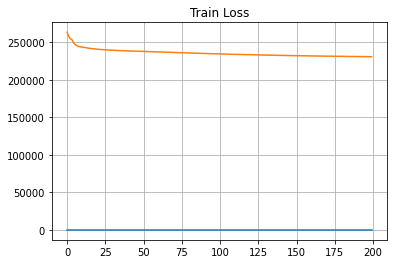

In [ ]:
plt.figure(figsize=(6,4))
plt.title('Train Loss')
plt.plot(loss_hist['D'])
plt.plot(loss_hist['G'])
plt.grid()
plt.show()

In [ ]:
x_A, x_B = next(iter(dataloader))

model.eval()
y = model(x_A, select='B')

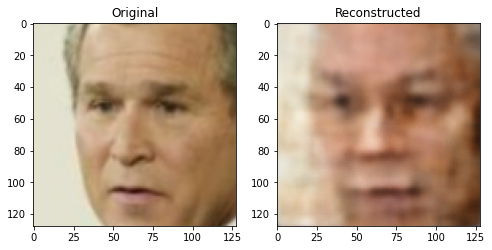

In [ ]:
sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])

plt.figure(figsize=(8,6))
plt.subplot(121)
plt.title('Original')
plt.imshow(x_A[2].permute(1,2,0).cpu().detach().numpy())
plt.subplot(122)
plt.title('Reconstructed')
rec = y[0][2].clamp(0,1)
rec_img = rec.permute(1,2,0).cpu().detach().numpy()
plt.imshow(rec_img)
#plt.imshow(cv2.filter2D(rec_img, -1, sharpen_kernel))
plt.show()

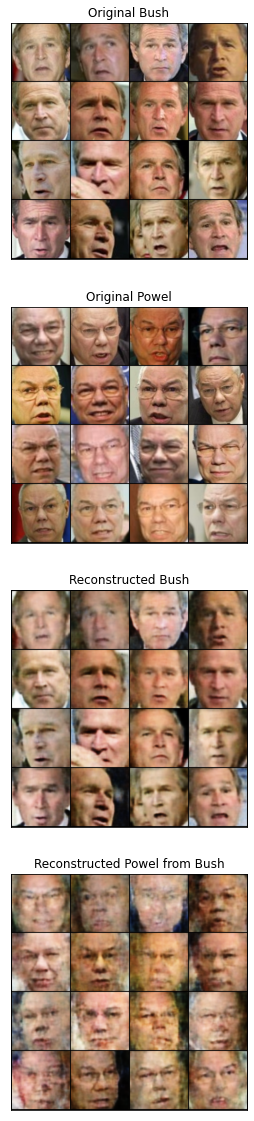

In [ ]:
plt.figure(figsize=(10,20))
plt.subplot(411)
plt.title('Original Bush')
disp_tensor = next(iter(dataloader))
A = disp_tensor[0]
grid_img = torchvision.utils.make_grid(list(A), nrow=4)
plt.imshow(grid_img.permute(1, 2, 0).cpu().detach().numpy())
plt.xticks([])
plt.yticks([])

plt.subplot(412)
plt.title('Original Powel')
B = disp_tensor[1]
grid_img = torchvision.utils.make_grid(list(B), nrow=4)
plt.imshow(grid_img.permute(1, 2, 0).cpu().detach().numpy())
plt.xticks([])
plt.yticks([])

model.eval()
y = model(disp_tensor[0], select='A')
y = y[0].clamp(0,1)
grid_img = torchvision.utils.make_grid(list(y), nrow=4)
plt.subplot(413)
plt.title('Reconstructed Bush')
plt.imshow(grid_img.permute(1,2,0).cpu().detach().numpy())
plt.xticks([])
plt.yticks([])

model.eval()
y = model(disp_tensor[0], select='B')
y = y[0].clamp(0,1)
grid_img = torchvision.utils.make_grid(list(y), nrow=4)
plt.subplot(414)
plt.title('Reconstructed Powel from Bush')
plt.imshow(grid_img.permute(1,2,0).cpu().detach().numpy())

plt.xticks([])
plt.yticks([])
plt.show()

For further investigation:

Try train additional neural regressor model that predicts face landmarks (input - image, targets - known landmarks, loss = L1Loss), create mask region in image with predicted landmarks, so that only face is obtained from image.
Use this face region as the inputs to the VAE-GAN model.

Try deblur the resulting images via ConditionalGAN (SRGAN, DeblurGAN):

this would be the nice candidate: https://github.com/KupynOrest/DeblurGAN

It is also supposed that in some cases applying spectral normalization in discriminator model is handy for better model convergence.

$W_{SN} = \frac{W}{\sigma W}, \sigma(W) = max_{h:h\neq0}\frac{||Wh||_2}{||h||_2}$



```
torch.nn.utils.parametrizations.spectral_norm(module, name='weight', n_power_iterations=1, eps=1e-12, dim=None)
```



*   $module (nn.Module)$ – containing module

* $name (str, optional)$ – name of weight parameter. Default: "weight".

* $n_power_iterations (int, optional)$ – number of power iterations to calculate spectral norm. Default: 1.

* $eps (float, optional)$ – epsilon for numerical stability in calculating norms. Default: 1e-12.

* $dim (int, optional)$ – dimension corresponding to number of outputs. Default: 0, except for modules that are instances of ConvTranspose{1,2,3}d, when it is 1


```
>>> snm = spectral_norm(nn.Linear(20, 40))
>>> snm
ParametrizedLinear(
in_features=20, out_features=40, bias=True
(parametrizations): ModuleDict(
    (weight): ParametrizationList(
    (0): _SpectralNorm()
    )
)
)
```









Also the most significant hyperparameter for GAN models is learning rate. Good values for start: 2e-4 for discriminator, 1e-4 for generator.


* Use not only vgg_face pretrained discriminator, but also use in final model pretrained autoencoder on same images
*   Add LR scheduler: torch.optim.lr_schedulers.StepLR
*   Apply torch.utils.parametrizations.spectral_norm() for Discriminator
* Use bigger amount and higher resolution images [256,256,3] for more complex model ($nn.Conv2d(3,256,1,1,0), BatchNorm2d(2)$)
* Apply normalization (T.Normalize). For pretrained face discriminator in forward method use iverse noramlization and normalize with respect to the given model

